<b>1</b> OBTENCIÓN DE DATOS

In [1]:
import definirCorrelacionVariables
from matplotlib import pyplot
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
import numpy as np
import pylab as pl
import math

data= definirCorrelacionVariables.getDataFromDataBase()
dataframeTrain,datosTrain,dictGeneralTrain = definirCorrelacionVariables.generarMatrizDatos(data,True)

data2= definirCorrelacionVariables.getDataFromDataBaseTest()
print(data2)
dataframeTest,datosTest,dictGeneralTest = definirCorrelacionVariables.generarMatrizDatos(data2,False)

716
key  ndvi len  716
key  volImage len  716
key  areaImage len  716
key  hImage len  716
key  dataIafNdvi len  716
key  maxRed len  716
key  minRed len  716
key  maxBlue len  716
key  meanRed len  716
key  minBlue len  716
key  maxGreen len  716
key  meanBlue len  716
key  minGreen len  716
key  meanGreen len  716
key  varianceRed len  716
key  maxHistGrVal len  716
key  maxHistValue len  716
key  varianceBlue len  716
key  maxHistBluVal len  716
key  varianceGreen len  716
key  criMean len  716
key  criMax len  716
key  criMin len  716
key  cgreenviMean len  716
key  cgreenviMax len  716
key  cgreenviMin len  716
key  cnirviMean len  716
key  cnirviMax len  716
key  cnirviMin len  716
key  gndviMean len  716
key  gndviMax len  716
key  gndviMin len  716
key  mcariOneMean len  716
key  mcariOneMax len  716
key  mcariOneMin len  716
key  mtviOneMean len  716
key  mtviOneMax len  716
key  mtviOneMin len  716
key  ngrdiMean len  716
key  ngrdiMax len  716
key  ngrdiMin len  716
key  ndv

<b>2</b> pre PROCESAMIENTO DE DATA

In [2]:
dataframeTest[["maxHistBluVal"]]

maxHistBluVal
0                2
1                2
2                2
3                2
4                2
..             ...
711              2
712              2
713              2
714              2
715              2

[716 rows x 1 columns]

3. OBTENCIÓN DE CORRELACIÓN MÚLTIPLE

SE CALCULA LA VARIABLE EL IAF
$Ac = \pi*r*g $

$g = \sqrt(h^2 + r^2) $

Se tiene que $r = Di/2$

$Ac = \pi*r*\sqrt(h^2 + r^2)$

$Ac = \pi*\frac{Di}{4}*\sqrt(4*h^2 + Di^2)$

Diametro

$diameter = 2*\sqrt(\frac{area}{\pi})$

In [3]:


areaLateralTrain = []
volumeFromDiameterTrain= []
diametrosTrain=[]
for index,x in enumerate(datosTrain.datosArea):
    diametro = 2*math.sqrt(x/math.pi)
    diametrosTrain.append(diametro)
    altura= datosTrain.datosAlturaCalculada[index]/100
    valueAreaLateral=diametro*math.sqrt((diametro*diametro)+4*(altura*altura))
    valueVolume = math.pi*diametro*diametro*altura*(1/6)
    volumeFromDiameterTrain.append(valueVolume)
    areaLateralTrain.append(valueAreaLateral)
areaLateralTest = []
volumeFromDiameterTest = []
diametrosTest=[]
for index,x in enumerate(datosTest.datosArea):
    diametro = 2*math.sqrt(x/math.pi)
    diametrosTest.append(diametro)
    altura= datosTest.datosAlturaCalculada[index]/100
    valueAreaLateral=diametro*math.sqrt((diametro*diametro)+4*(altura*altura))
    valueVolume = math.pi*diametro*diametro*altura*(1/6)
    volumeFromDiameterTest.append(valueVolume)
    areaLateralTest.append(valueAreaLateral)


<b style="color:orange;">LAI CALCULATED FROM EQUATION BASED ON VOLUME and AREA</b>

Se calcula el IAF usando Volumen Imagen y Yield

$IAF =  0.0134 + 2.7791 Vc$

Se calcula IAF usando Area Lateral y Yield

$IAF =  -0.5786 + 0.7896 Alat $


In [4]:

IAF_from_volumeTrain = definirCorrelacionVariables.objective(datosTrain.datosVolumenImagen, 2.7791,0.0134)
IAF_from_areaTrain = definirCorrelacionVariables.objective(areaLateralTrain, 0.7896,-0.5786)
d = {"latArea":areaLateralTrain, "IAF_VOL":IAF_from_volumeTrain, "IAF_AREA":IAF_from_areaTrain}
dictGeneralTrain.update(d)
dframeFinalTrain = pd.DataFrame(data=dictGeneralTrain)

IAF_from_volumeTest = definirCorrelacionVariables.objective(datosTest.datosVolumenImagen, 2.7791,0.0134)
IAF_from_areaTest = definirCorrelacionVariables.objective(areaLateralTest, 0.7896,-0.5786)
d = {"latArea":areaLateralTest, "IAF_VOL":IAF_from_volumeTest, "IAF_AREA":IAF_from_areaTest}
dictGeneralTest.update(d)
dframeFinalTest = pd.DataFrame(data=dictGeneralTest)



Yield Promedio  5169.166319967175
Yield KG Por Planta  1.1889082535924502
7150.891747213299
0      0.971163
1      0.361763
2      1.184471
3      0.953911
4      0.792817
         ...   
711    0.734848
712    0.665995
713    0.561938
714    0.551884
715    0.204613
Name: volImage, Length: 716, dtype: float64


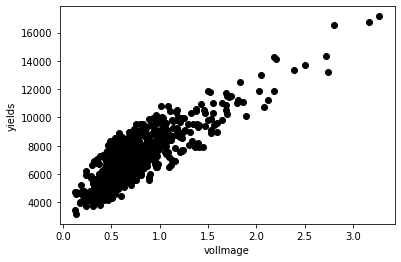

Total Granos Por Planta 7150.891747213299
Total Peso KG Pred Por Planta 4934.1153055771765


In [6]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
dfsXtrain=dframeFinalTrain.loc[:,["volImage","criMax","ndviMean","maxBlue","latArea","maxGreen","saviMax","tviMax","ndviMax","maxHistBluVal"]]
dfsTest=dframeFinalTest.loc[:,["volImage","criMax","ndviMean","maxBlue","latArea","maxGreen","saviMax","tviMax","ndviMax","maxHistBluVal"]]
xTrain= dfsXtrain.values
yTrain = dframeFinalTrain.yields.values

lr_multiple = linear_model.LinearRegression()

lr_multiple.fit(xTrain,yTrain)

Y_pred_test=lr_multiple.predict(dfsTest.values)

print("Yield Promedio ",np.mean(yTrain))
print("Yield KG Por Planta ",np.mean(yTrain)*(0.00023))

print(np.sum(Y_pred_test)/Y_pred_test.size)

print(dfsTest["volImage"])

pyplot.scatter(dfsTest["volImage"],Y_pred_test,c="black")
pyplot.xlabel("volImage")
pyplot.ylabel("yields")

pyplot.show()

numberGrains = (np.mean(Y_pred_test))

pesoPorPlanta=numberGrains*(0.00023)
print("Total Granos Por Planta",numberGrains)
print("Total Peso KG Pred Por Planta",pesoPorPlanta*3000)
